# TensorFlow basics

In [2]:
# Let's import tensorflow
import tensorflow as tf

## 1. Tensors

In [3]:
# Define a tensor
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


TensorFlow implements standard mathematical operations on tensors:

In [4]:
# Sum of tensors
x + x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [5]:
# Product with a constant
5 * x

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[ 5., 10., 15.],
       [20., 25., 30.]], dtype=float32)>

In [6]:
# Transpose
transposed_x = tf.transpose(x)
transposed_x

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 4.],
       [2., 5.],
       [3., 6.]], dtype=float32)>

In [7]:
# Tensor multiplication
x @ transposed_x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[14., 32.],
       [32., 77.]], dtype=float32)>

In [8]:
# Tensor concatenation
tf.concat([x, x, x], axis=0) 

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.],
       [1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [9]:
# Applying functions
tf.nn.softmax(x, axis=-1)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.09003057, 0.24472848, 0.6652409 ],
       [0.09003057, 0.24472848, 0.6652409 ]], dtype=float32)>

In [10]:
# Sum all elements of the matrix
tf.reduce_sum(x)

<tf.Tensor: shape=(), dtype=float32, numpy=21.0>

TensorFlow can use accelerator hardware like GPUs to execute operations very quickly:

In [11]:
# Check if TF is using GPU
bool(tf.config.list_physical_devices("GPU"))

True

## 2. Variables

tf.Tensor objects are immutable. To store mutable objects, use tf.Variable.

In [22]:
# Define a variable
var = tf.Variable([0.0, 0.0, 0.0])
var

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [23]:
# Assing a new tensor value to the variable
var.assign([1, 2, 3])
var

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [24]:
# Add a value to a variable
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

## 3. Automatic differentiation
TF uses automatic differentiation to compute gradients. This can be used to calculate the gradient of a model's error or loss with respect to its weights.

In [25]:
x = tf.Variable(1.0)
x

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.0>

In [26]:
# Let's define a function to perform some calculation
def f(x):
  y = x**2 + 2*x - 5
  return y

In [27]:
# At x=1.0, f(x=1.0) = -2.0. 
f(x)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [29]:
# TensorFlow can calculate the derivate of that function
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # derivate of y with respect to x
g_x  # f'(x=1.0) = 4.0

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

## 4. Graphs and tf.function
TensorFlow provides tools for:
- Performance optimization: to speed up training and inference.
- Export: to save the model

These require that you use tf.function to separate your pure-TensorFlow code from Python.


In [30]:
# Let's define a function decorated with tf.function.
@tf.function
def my_func(x):
  print("Tracing")  # Python pure code
  return tf.reduce_sum(x)  # TensorFlow code

In [31]:
# All the code is executed on the first call of the function
x = tf.constant([1, 2, 3])
my_func(x)

Tracing


<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [32]:
# But no on the next calls
x = tf.constant([10, 9, 8])
my_func(x)

<tf.Tensor: shape=(), dtype=int32, numpy=27>

In [33]:
# Except if inputs have a different signature (shape and dtype)
x = tf.constant([10.0, 9.1, 8.2], dtype=tf.float32)
my_func(x)

Tracing


<tf.Tensor: shape=(), dtype=float32, numpy=27.3>

## 5. Modules, layers and models

tf.Module is a class for managing tf.Variable objects and the tf.function that operate on them.

- You can save and restore the values of your variables using tf.train.Checkpoint.
- You can import and export the tf.Variable values and the tf.function graphs using tf.saved_model. This allows you to run your model independently of the Python program that created it.

In [34]:
# Create a custom module, inherited from tf.Module
class MyModule(tf.Module):
  def __init__(self, value):
    self.weight = tf.Variable(value)

  @tf.function
  def multiply(self, x):
    return x * self.weight

In [35]:
# Create a MyModule object and do some operations with it
mod = MyModule(3)
mod.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

In [36]:
# Save the module
save_path = './saved'
tf.saved_model.save(mod, save_path)

INFO:tensorflow:Assets written to: ./saved/assets


The resulting SavedModel is independent of the code that created it. You can load a SavedModel from Python, other language bindings, or TensorFlow Serving. You can also convert it to run with TensorFlow Lite or TensorFlow JS.

In [37]:
# Example of realoading the model using Python
reloaded = tf.saved_model.load(save_path)
reloaded.multiply(tf.constant([1, 2, 3]))

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 6, 9], dtype=int32)>

## 6. Training loops

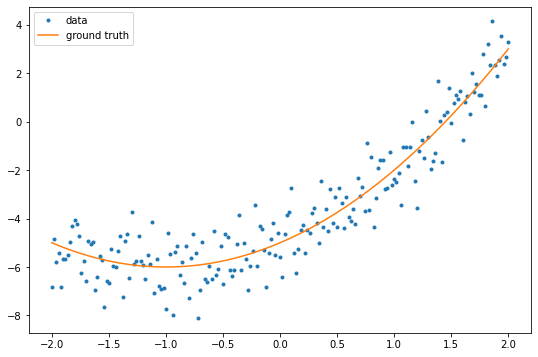

In [38]:
# First, create some example data
import matplotlib
from matplotlib import pyplot as plt

matplotlib.rcParams['figure.figsize'] = [9, 6]

# Create some data
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

def f(x):
  y = x**2 + 2*x - 5
  return y

y_clean = f(x)

# And some data with random noise
y = f(x) + tf.random.normal(shape=[201])

# And visualize the created data
plt.plot(x.numpy(), y.numpy(), '.', label="data")
plt.plot(x, y_clean, label="ground truth")
plt.legend();


In [40]:
# Now, let's create a model
class Model(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(units=units,
                                        activation=tf.nn.relu,
                                        kernel_initializer=tf.random.normal,
                                        bias_initializer=tf.random.normal)
    self.dense2 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    # For Keras layers/models, implement `call` instead of `__call__`.
    x = x[:, tf.newaxis]
    x = self.dense1(x)
    x = self.dense2(x)
    return tf.squeeze(x, axis=1)

model = Model(64)

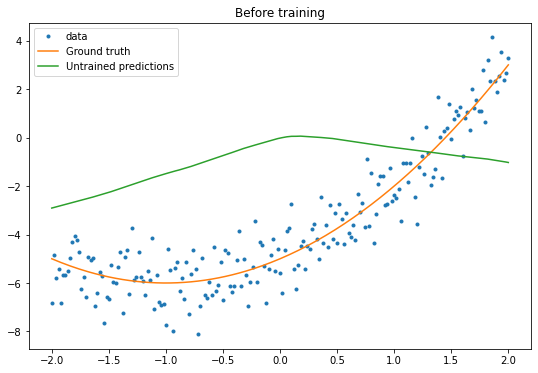

In [41]:
# And add the untrained predictions to the graph
plt.plot(x.numpy(), y.numpy(), '.', label='data')
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Untrained predictions')
plt.title('Before training')
plt.legend();

In [43]:
# Let's now write a basic training loop
variables = model.variables

optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(1000):
  with tf.GradientTape() as tape:
    prediction = model(x)
    error = (y-prediction)**2
    mean_error = tf.reduce_mean(error)
  gradient = tape.gradient(mean_error, variables)
  optimizer.apply_gradients(zip(gradient, variables))

  if step % 100 == 0:
    print(f"MSE={mean_error.numpy()}")

MSE=14.412565231323242
MSE=0.9452175498008728
MSE=0.9072592854499817
MSE=0.8862162828445435
MSE=0.8723661303520203
MSE=0.8624101877212524
MSE=0.8544606566429138
MSE=0.8484035730361938
MSE=0.8437608480453491
MSE=0.8398839235305786


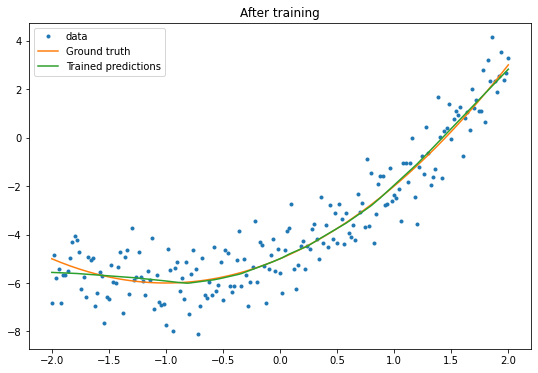

In [46]:
# Plot the results of the trained model
plt.plot(x.numpy(),y.numpy(), '.', label="data")
plt.plot(x, f(x),  label='Ground truth')
plt.plot(x, model(x), label='Trained predictions')
plt.title('After training')
plt.legend();

The training could have been done with Model.compile and Model.fit too.

In [48]:
new_model = Model(64)

new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.optimizers.SGD(learning_rate=0.01))

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)


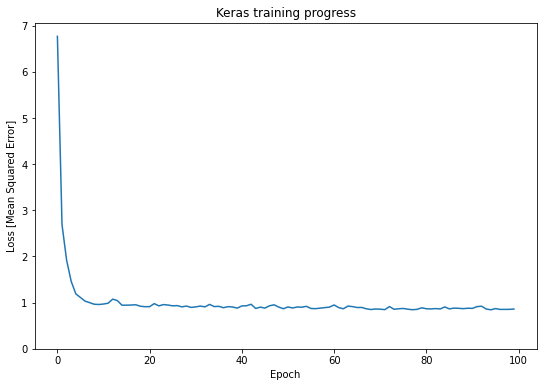

In [49]:
plt.plot(history.history["loss"])
plt.xlabel("Epoch")
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');